# A numerical variability approach to results stability tests and its application to neuroimaging

This Jupyter notebook reproduces figures present in the paper.

In [1]:
import glob
import os

import joblib
import nibabel
import nilearn.masking
import numpy as np
import pandas as pd
import significantdigits as sdg
import tqdm
from joblib import Memory, Parallel, delayed
import plotly.express as px
import plotly.graph_objects as go
import nilearn.plotting
import matplotlib.pyplot as plt
from matplotlib import cm

## Table II. Dimensions, voxels resolutions, age and sex of each subject in the dataset.

In [2]:
data = {
    "Index": [1, 2, 3, 4, 5, 6, 7, 8],
    "Dataset": [
        "ds000256",
        "ds000256",
        "ds001600",
        "ds001748",
        "ds001748",
        "ds001771",
        "ds002338",
        "ds002338",
    ],
    "Subject": [
        "sub-CTS201",
        "sub-CTS210",
        "sub-1",
        "sub-adult15",
        "sub-adult16",
        "sub-36",
        "sub-xp201",
        "sub-xp207",
    ],
    "Dimension (x, y, z)": [
        "256 × 256 × 256",
        "224 × 256 × 256",
        "176 × 256 × 256",
        "176 × 240 × 256",
        "176 × 240 × 256",
        "256 × 320 × 320",
        "176 × 512 × 512",
        "176 × 512 × 512",
    ],
    "Voxel resolution (x, y, z)": [
        "1.0 × 1.0 × 1.0",
        "0.8 × 0.8 × 0.8",
        "1.0 × 1.0 × 1.0",
        "1.0 × 1.0 × 1.0",
        "1.0 × 1.0 × 1.0",
        "0.8 × 0.8 × 0.8",
        "1.0 × 0.5 × 0.5",
        "1.0 × 0.5 × 0.5",
    ],
    "Data type": [
        "int16",
        "int16",
        "int16",
        "float32",
        "float32",
        "int16",
        "int16",
        "int16",
    ],
    "Age (years)": [8.68, 7.63, "-", 21, 21, 22, 41, 39],
    "Sex": ["M", "F", "-", "M", "F", "F", "F", "M"],
}

subjects_table = pd.DataFrame(data)

def get_index(dataset, subject):
    return subjects_table[
        (subjects_table["Dataset"] == dataset) & (subjects_table["Subject"] == subject)
    ]["Index"].values[0]

def get_dataset_subject(index):
    return subjects_table[subjects_table["Index"] == index][["Dataset", "Subject"]].values[0]

subjects_table

,Index,Dataset,Subject,"Dimension (x, y, z)","Voxel resolution (x, y, z)",Data type,Age (years),Sex
0,1,ds000256,sub-CTS201,256 × 256 × 256,1.0 × 1.0 × 1.0,int16,8.68,M
1,2,ds000256,sub-CTS210,224 × 256 × 256,0.8 × 0.8 × 0.8,int16,7.63,F
2,3,ds001600,sub-1,176 × 256 × 256,1.0 × 1.0 × 1.0,int16,-,-
3,4,ds001748,sub-adult15,176 × 240 × 256,1.0 × 1.0 × 1.0,float32,21,M
4,5,ds001748,sub-adult16,176 × 240 × 256,1.0 × 1.0 × 1.0,float32,21,F
5,6,ds001771,sub-36,256 × 320 × 320,0.8 × 0.8 × 0.8,int16,22,F
6,7,ds002338,sub-xp201,176 × 512 × 512,1.0 × 0.5 × 0.5,int16,41,F
7,8,ds002338,sub-xp207,176 × 512 × 512,1.0 × 0.5 × 0.5,int16,39,M


In [3]:
# Compute significant digits for each perturbation, subject and FWHM

def load_T1w(directory, dataset, subject):
    t1 = f"{subject}_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz"
    path = os.path.join(directory, f"*{dataset}*", "**", "anat", t1)
    return glob.glob(path, recursive=True)


def load_brain_mask(directory, dataset, subject):
    mask = f"{subject}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    path = os.path.join(directory, f"*{dataset}*", "**", "anat", mask)
    return glob.glob(path, recursive=True)


def compute_brain_mask_union(brain_masks):
    UNION = 0
    mask_union = nilearn.masking.intersect_masks(brain_masks, threshold=UNION)
    return mask_union


def apply_mask(t1ws, mask_union, smoothing_fwhm=None):
    import nilearn.masking

    if smoothing_fwhm == 0:
        smoothing_fwhm = None
    t1w_preproc = np.fromiter(
        (
            nilearn.masking.apply_mask(t1w, mask_union, smoothing_fwhm=smoothing_fwhm)
            for t1w in t1ws
        ),
        dtype=np.dtype((np.float32, np.count_nonzero(mask_union.get_fdata()))),
    )
    return t1w_preproc


def get_output_path(cache, perturbation, index, fwhm, normalized):
    normalized = "normalized" if normalized else "unnormalized"
    return os.path.join(
        cache, normalized, f"{perturbation}-Subject-{index}_FWHM-{fwhm}.npz"
    )

def compute_significant_digits_unnormalized(voxels, mask_union, output_normalized):
    reference = np.mean(voxels, axis=0)
    sig = sdg.significant_digits(voxels, reference=reference)
    np.savez_compressed(output_normalized, sig=sig, mask=mask_union)


def compute_significant_digits_normalized(voxels, mask_union, output_unnormalized):
    iterator = ((v - v.min()) / (v.max() - v.min()) for v in voxels)
    voxels = np.fromiter(iter=iterator, dtype=np.dtype((np.float32, voxels.shape[1:])))
    reference = np.mean(voxels, axis=0)
    sig = sdg.significant_digits(voxels, reference=reference)
    np.savez_compressed(output_unnormalized, sig=sig, mask=mask_union)


def compute_significant_digits(
    t1ws, mask_union, fwhm, perturbation, index, cache, force=False
):
    output_normalized = get_output_path(cache, perturbation, index, fwhm, True)
    output_unnormalized = get_output_path(cache, perturbation, index, fwhm, False)
    voxels = apply_mask(t1ws, mask_union, fwhm)
    if not os.path.exists(output_normalized) or force:
        compute_significant_digits_normalized(voxels, mask_union, output_normalized)
    if not os.path.exists(output_unnormalized) or force:
        compute_significant_digits_unnormalized(voxels, mask_union, output_unnormalized)


for perturbation in ["rr", "rs"]:
    print(f"Perturbation {perturbation}")
    for index in subjects_table["Index"]:
        print("Preprocessing subject", index)
        directory = f"outputs/20.2.1/{perturbation}"
        fwhms = []
        for i in range(0, 21):
            output_normalized = get_output_path("significant_digits", perturbation, index, i, True)
            output_unnormalized = get_output_path("significant_digits", perturbation, index, i, False)
            if not os.path.exists(output_normalized) or not os.path.exists(output_unnormalized):
                fwhms.append(i)
            else:
                continue

        if len(fwhms) == 0:
            print("All FWHMs already computed")
            continue
        
        dataset, subject = get_dataset_subject(index)        
        t1ws = load_T1w(directory, dataset, subject)
        brain_masks = load_brain_mask(directory, dataset, subject)
        mask_union = compute_brain_mask_union(brain_masks)

        def producer():
            for fwhm in range(0, 21):
                yield (
                    t1ws,
                    mask_union,
                    fwhm,
                    perturbation,
                    index,
                    "significant_digits",
                )

        # Adjust n_jobs according to ressources available
        Parallel(n_jobs=8)(
            delayed(compute_significant_digits)(*args)
            for args in tqdm.tqdm(producer(), unit="FWHM")
        )

Perturbation rr
Preprocessing subject 1
All FWHMs already computed
Preprocessing subject 2
All FWHMs already computed
Preprocessing subject 3
All FWHMs already computed
Preprocessing subject 4
All FWHMs already computed
Preprocessing subject 5
All FWHMs already computed
Preprocessing subject 6
All FWHMs already computed
Preprocessing subject 7
All FWHMs already computed
Preprocessing subject 8
All FWHMs already computed
Perturbation rs
Preprocessing subject 1
All FWHMs already computed
Preprocessing subject 2
All FWHMs already computed
Preprocessing subject 3
All FWHMs already computed
Preprocessing subject 4
All FWHMs already computed
Preprocessing subject 5
All FWHMs already computed
Preprocessing subject 6
All FWHMs already computed
Preprocessing subject 7
All FWHMs already computed
Preprocessing subject 8
All FWHMs already computed


In [54]:
def compute_sig_mean(perturbation, index, fwhm, normalized=True):
    normalized = "normalized" if normalized else "unnormalized"
    npz = os.path.join(
        "significant_digits",
        normalized,
        f"{perturbation}-Subject-{index}_FWHM-{fwhm}.npz",
    )
    data = np.load(npz)
    sig = data["sig"]
    return np.mean(sig)

def run(perturbation, normalized):
    sig = {
        index: Parallel(n_jobs=21)(
            delayed(compute_sig_mean)(perturbation, index, i, normalized=True)
            for i in range(0, 21)
        )
        for index in subjects_table["Index"]
    }
    sig = (
        pd.DataFrame.from_dict(sig)
        .unstack()
        .reset_index()
        .rename(columns={"level_0": "Index", "level_1": "FWHM", 0: "Significant bits"})
    )
    sig["Perturbation"] = perturbation
    return sig


significant_digits_normalized = pd.concat([run("rr",True), run("rs",True)])
significant_digits_unnormalized = pd.concat([run("rr",False), run("rs",False)])


In [5]:
def unmask(perturbation, index, fwhm, normalized=True):
    normalized = "normalized" if normalized else "unnormalized"
    npz = os.path.join(
        "significant_digits",
        normalized,
        f"{perturbation}-Subject-{index}_FWHM-{fwhm}.npz",
    )
    data = np.load(npz, allow_pickle=True)
    sig, mask_union = data["sig"], data["mask"]
    return nilearn.masking.unmask(sig, mask_union.item())


def view_significant_digits_brain(
    perturbation,
    index,
    fwhm,
    title=None,
    vmax=12,
    vmin=0,
    discrete=False,
    normalized=True,
):
    if discrete:
        cmap = plt.colormaps.get_cmap("RdYlGn").resampled(np.abs(vmax - vmin))
    else:
        cmap = plt.colormaps.get_cmap("RdYlGn")
    sig_img = unmask(perturbation, index, fwhm, normalized=normalized)
    voxels = sig_img.get_fdata()
    sig_img_thresholded = nibabel.Nifti1Image(
        np.where(voxels <= 0, 0, voxels), sig_img.affine
    )
    return nilearn.plotting.view_img(
        sig_img_thresholded,
        cmap=cmap,
        symmetric_cmap=False,
        black_bg=True,
        vmin=vmin,
        vmax=vmax,
        bg_img=None,
        cut_coords=(0, 0, 0),
        title=title,
    )


def plot_ieee_brain(index, fwhm):
    output_path = os.path.join(
        "significant_digits",
        "figures",
        "ieee",
        f"Subject-{index}_FWHM-{fwhm}.png",
    )
    if os.path.exists(output_path):
        return
    if fwhm == 0:
        fwhm = None
    directory = f"outputs/20.2.1/ieee"
    dataset, subject = get_dataset_subject(index)
    t1w = load_T1w(directory, dataset, subject)[0]
    brain_mask = load_brain_mask(directory, dataset, subject)[0]
    voxel = nilearn.masking.apply_mask(t1w, brain_mask, smoothing_fwhm=fwhm)
    t1w_masked = nilearn.masking.unmask(voxel, brain_mask)
    return nilearn.plotting.plot_anat(
        t1w_masked,
        output_file=output_path,
        cut_coords=(0, 0, 0),
        draw_cross=False,
        black_bg=True,
        bg_img=None,
    )


def plot_significant_digits_brain(
    perturbation,
    index,
    fwhm,
    title=None,
    vmax=12,
    vmin=0,
    discrete=True,
    normalized=True,
):
    if discrete:
        cmap = plt.colormaps.get_cmap("RdYlGn").resampled(np.abs(vmax - vmin))
    else:
        cmap = plt.colormaps.get_cmap("RdYlGn")
    output_path = os.path.join(
        "significant_digits",
        "figures",
        "normalized" if normalized else "unnormalized",
        f"{perturbation}-Subject-{index}_FWHM-{fwhm}.png",
    )
    if os.path.exists(output_path):
        return

    sig_img = unmask(perturbation, index, fwhm, normalized=normalized)
    voxels = sig_img.get_fdata()
    sig_img_thresholded = nibabel.Nifti1Image(
        np.where(voxels <= 0, 0, voxels), sig_img.affine
    )

    return nilearn.plotting.plot_anat(
        sig_img_thresholded,
        cmap=cmap,
        # symmetric_cmap=False,
        black_bg=True,
        threshold=0.01,
        vmin=vmin,
        vmax=vmax,
        bg_img=None,
        cut_coords=(0, 0, 0),
        draw_cross=False,
        title=title,
        output_file=output_path,
    )


def ieee_producer():
    for index in subjects_table["Index"]:
        for fwhm in range(0, 21):
            yield (index, fwhm)

def producer():
    for perturbation in ["rr", "rs"]:
        for index in subjects_table["Index"]:
            for fwhm in range(0, 21):
                yield (perturbation, index, fwhm)

Parallel(n_jobs=16)(delayed(plot_ieee_brain)(*args) for args in tqdm.tqdm(ieee_producer(), unit="image"))

Parallel(n_jobs=16)(
    delayed(plot_significant_digits_brain)(*args, discrete=True, normalized=False)
    for args in tqdm.tqdm(producer(), unit="image")
)
none=Parallel(n_jobs=16)(
    delayed(plot_significant_digits_brain)(*args, discrete=True, normalized=True)
    for args in tqdm.tqdm(producer(), unit="image")
)

168image [00:01, 131.11image/s]
336image [00:00, 2564.43image/s]
336image [00:00, 2968.01image/s]


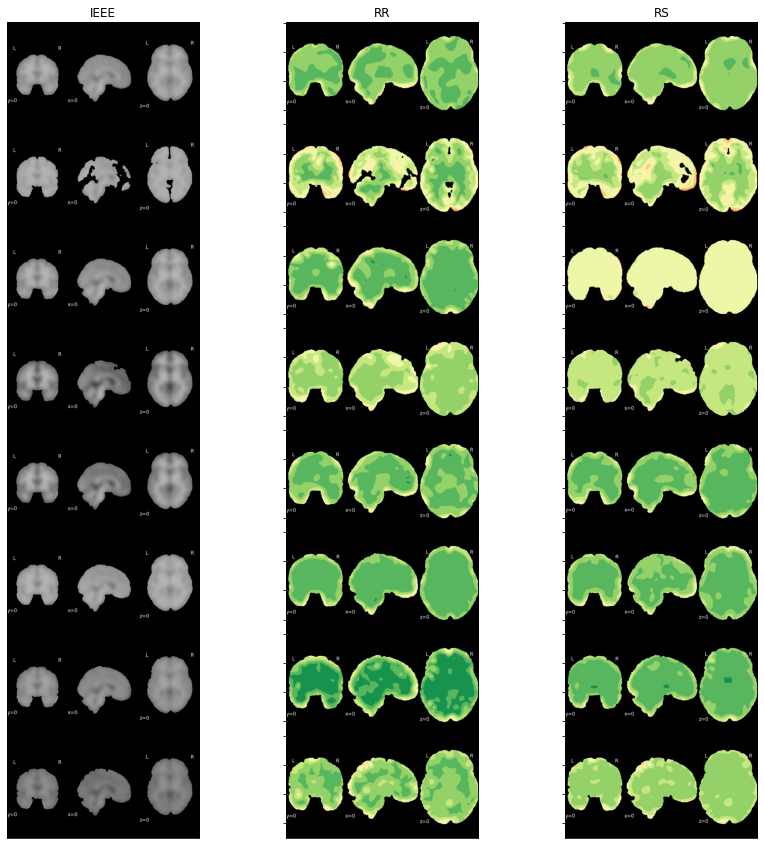

In [6]:
import matplotlib.pyplot as plt


def create_grid_numerical_variability(normalized, fwhm):
    plt.close()
    prefix = os.path.join("significant_digits", "figures")
    normalized = "normalized" if normalized else "unnormalized"

    f, axarr = plt.subplots(
        8,
        3,
        figsize=(15, 15),
        sharex=True,
        sharey=True,
        gridspec_kw={"hspace": 0, "wspace": 0},
    )

    for row, index in enumerate(subjects_table["Index"], start=1):
        ieee_filename = os.path.join(prefix, "ieee", f"Subject-{index}_FWHM-{fwhm}.png")
        rr_filename = os.path.join(
            prefix, normalized, f"rr-Subject-{index}_FWHM-{fwhm}.png"
        )
        rs_filename = os.path.join(
            prefix, normalized, f"rs-Subject-{index}_FWHM-{fwhm}.png"
        )

        ieee_img = plt.imread(ieee_filename)
        rr_img = plt.imread(rr_filename)
        rs_img = plt.imread(rs_filename)

        axarr[row - 1, 0].set_title(f"IEEE")
        axarr[row - 1, 0].tick_params(
            axis="x", bottom=False, labelbottom=False, top=False, labeltop=False
        )
        axarr[row - 1, 0].tick_params(
            axis="y", right=False, labelright=False, left=False, labelleft=False
        )
        axarr[row - 1, 1].set_title(f"RR")
        axarr[row - 1, 1].tick_params(
            axis="x", bottom=False, labelbottom=False, top=False, labeltop=False
        )
        axarr[row - 1, 2].set_title(f"RS")
        axarr[row - 1, 2].tick_params(
            axis="x", bottom=False, labelbottom=False, top=False, labeltop=False
        )

        axarr[row - 1, 0].imshow(ieee_img)
        axarr[row - 1, 1].imshow(rr_img)
        axarr[row - 1, 2].imshow(rs_img)

    plt.subplots_adjust(wspace=0, hspace=0)
    
create_grid_numerical_variability(normalized=False, fwhm=15)

## Figure 3: Numerical variability measured for subjects 1 to 8 (from top to bottom) across n=30 perturbed samples, with FWHM = 15 mm.

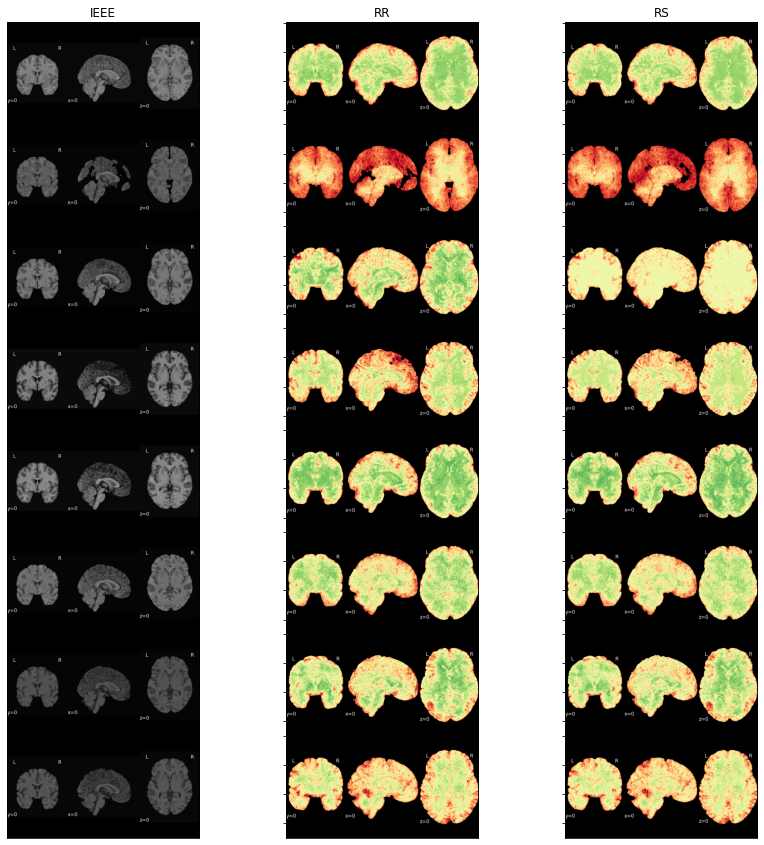

In [7]:
create_grid_numerical_variability(normalized=False, fwhm=0)

## Figure 3: Numerical variability measured for subjects 1 to 8 (from top to bottom) across n=30 perturbed samples, with FWHM=0mm. 

In [80]:
d = significant_digits_normalized.groupby("Perturbation").describe()
d["Significant bits"]["min"]["rr"]

2.756291067108165

In [82]:
from plotly.subplots import make_subplots
from polars import col


def plot_significant_digits(sig_data, title):
    sig_min = min(min(v) for v in rr.values())
    sig_max = max(max(v) for v in rr.values())
    fig = px.line(sig_data, markers=True, title=title)
    fig.update_xaxes(title="FWHM (mm)")
    fig.update_yaxes(title="Significant bits")
    fig.update_legends(title="Subjects")
    fig.add_hline(
        y=sig_min,
        line_dash="dot",
        line_color="black",
        opacity=0.5,
        annotation_text=f"{sig_min:.2f}",
    )
    fig.add_hline(
        y=sig_max,
        line_dash="dot",
        line_color="black",
        opacity=0.5,
        annotation_text=f"{sig_max:.2f}",
    )
    return fig

def plot_dot_line(fig, y, col):
    fig.add_hline(
        y=y,
        line_dash="dot",
        line_color="black",
        opacity=0.5,
        annotation_text=f"{y:.2f}",
        row=1,
        col=col,
    )


def plot_sig(sig):

    fig = px.line(sig, markers=True, x="FWHM", y="Significant bits", color="Index", facet_col="Perturbation", title="Significant bits")
    fig.update_xaxes(title="FWHM (mm)")
    fig.update_layout(font_family="Serif")
    fig.update_legends(orientation='h', yanchor="bottom", y=-.50, xanchor="center", x=0.5, bgcolor='rgba(0,0,0,0)', title="Subjects")
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1].upper()))

    stats = sig.groupby("Perturbation").describe()
    for col, perturbation in enumerate(["rr", "rs"], start=1):
        plot_dot_line(fig, stats["Significant bits"]["min"][perturbation], col)
        plot_dot_line(fig, stats["Significant bits"]["max"][perturbation], col)
    return fig
    
plot_sig(significant_digits_normalized)

## Figure 2: Voxel-wise means of significant bits measured across n=30 perturbed samples for RR and RS perturbations and 8 subjects

In [260]:
def load_pickle_files(files):
    """
    Load all pickle files in a directory
    """
    df = pd.concat(pd.DataFrame(pd.read_pickle(file)) for file in files)
    return df

In [264]:
version_experiments = glob.glob("pickles/template/*.pkl", recursive=True)
version_df = load_pickle_files(version_experiments)
version_df.groupby(
    [
        "reference_version",
        "reference_dataset",
        "reference_subject",
        "reference_perturbation",
        "reference_template",
        "reference_fwhm",
        "target_dataset",
        "target_subject",
        "target_template",
        "confidence",
    ],
    group_keys=True,
).apply(lambda x: x)
bonferroni = version_df[version_df["method"] == "fwe-bonferroni"]
# For Bonferroni correction, a test passes if the number of rejected voxels is 0
bonferroni.loc[:, "pass"] = bonferroni["reject"] < 1
bonferroni.loc[:, "alpha"] = 1 - bonferroni["confidence"]
bonferroni = pd.merge(
    bonferroni,
    subjects_table[["Index", "Dataset", "Subject"]],
    left_on="target_subject",
    right_on="Subject",
)

<ipython-input-264-68e28be1d513>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-264-68e28be1d513>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [259]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

colorblind_palette = ["#D55E00", "#009E73"]

def extract_noise_level(template):
    # Extract noise level from MNI152NLin2009cAsymNoised0001
    noise = int(template.split("Noised")[1])
    return f"{noise / 10:.1f}%"


def rotate_row_titles(fig, row_titles):
    for annotation in fig["layout"]["annotations"]:
        if annotation["text"] in row_titles:
            annotation["textangle"] = 0
            annotation["x"] = 1
            annotation["xref"] = "paper"
            annotation["xanchor"] = "left"
            annotation["yref"] = "paper"
            annotation["yanchor"] = "middle"


def plot_version(df):
    rr = df[df["reference_perturbation"] == "rr"]
    rs = df[df["reference_perturbation"] == "rs"]

    templates = df["target_template"].unique()
    templates.sort()
    indexes = df["Index"].unique()
    indexes.sort()

    column_titles = list(map(str, indexes))
    row_titles = [extract_noise_level(template) for template in templates]

    fig = make_subplots(
        rows=2 * templates.size,
        cols=indexes.size,
        column_titles=column_titles,
        row_titles=2 * row_titles,
        shared_xaxes=True,
        shared_yaxes=True,
        x_title="FWHM (mm)",
        y_title="α threshold",
        vertical_spacing=0.005,
        horizontal_spacing=0.005,
    )
    alpha = df["alpha"].unique()
    alpha.sort()
    alpha = np.flip(alpha)

    x = list(map(str, df["reference_fwhm"].unique()))
    y = [f"{alpha:.3f}" for alpha in alpha]

    # Plot RR
    for i, template in enumerate(templates, start=1):
        for j, index in enumerate(indexes, start=1):
            data = rr[(rr["target_template"] == template) & (rr["Index"] == index)]
            fig.add_trace(
                go.Heatmap(
                    z=data.pivot(index="reference_fwhm", columns="alpha", values="pass")
                    .to_numpy()
                    .astype(int)
                    .T,
                    x=x,
                    y=y,
                    colorscale=colorblind_palette,
                    zmin=0,
                    zmax=1,
                    showscale=False,
                ),
                row=i,
                col=j,
            )

    # Plot RS
    for i, template in enumerate(templates, start=1):
        for j, index in enumerate(indexes, start=1):
            data = rs[(rs["target_template"] == template) & (rs["Index"] == index)]
            fig.add_trace(
                go.Heatmap(
                    z=data.pivot(index="reference_fwhm", columns="alpha", values="pass")
                    .to_numpy()
                    .astype(int)
                    .T,
                    x=x,
                    y=y,
                    colorscale=colorblind_palette,
                    zmin=0,
                    zmax=1,
                    showscale=False,
                ),
                row=i + templates.size,
                col=j,
            )

    fig.add_annotation(
        text="RR",
        x=1.125,
        y=0.763,
        xref="paper",
        yref="paper",
        showarrow=False,
        font_size=20,
    )
    fig.add_annotation(
        text="RS",
        x=1.125,
        y=0.238,
        xref="paper",
        yref="paper",
        showarrow=False,
        font_size=20,
    )

    fig.update_layout(coloraxis_showscale=False)
    fig.update_traces(showlegend=False)
    fig.update_coloraxes(showscale=False)
    fig.update_layout(font_family="Serif", showlegend=False)
    rotate_row_titles(fig, row_titles)
    fig.update_layout(
        width=800,
        height=1400,
        title={
            "text": "Subjects",
            "xanchor": "center",
            "x": 0.5,
            "font_size": 20,
        },
    )

    return fig


plot_version(bonferroni)

### Figure 6: Corrupted template check for RR (top) and RS (bottom) modes. The stability tests correctly rejected results produced with corrupted templates beyond a subject-dependent threshold of corrupted voxels.

In [266]:
version_experiments = glob.glob("pickles/versions/*.pkl", recursive=True)
version_df = load_pickle_files(version_experiments)
version_df.groupby(
    [
        "reference_version",
        "reference_dataset",
        "reference_subject",
        "reference_perturbation",
        "reference_template",
        "reference_fwhm",
        "target_dataset",
        "target_subject",
        "target_template",
        "confidence",
    ],
    group_keys=True,
).apply(lambda x: x)
bonferroni = version_df[version_df["method"] == "fwe-bonferroni"]
# For Bonferroni correction, a test passes if the number of rejected voxels is 0
bonferroni.loc[:, "pass"] = bonferroni["reject"] < 1
bonferroni.loc[:, "alpha"] = 1 - bonferroni["confidence"]
bonferroni = pd.merge(
    bonferroni,
    subjects_table[["Index", "Dataset", "Subject"]],
    left_on="target_subject",
    right_on="Subject",
)
bonferroni

<ipython-input-266-954053f9370f>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-266-954053f9370f>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,reference_version,reference_architecture,reference_perturbation,reference_prefix,reference_dataset,reference_subject,reference_template,reference_sample_size,reference_fwhm,reference_mask,target_version,target_architecture,target_perturbation,target_prefix,target_dataset,target_subject,target_template,target_filename,kth_round,nb_round,confidence,reject,tests,method,pass,alpha,Index,Dataset,Subject
0,20.2.1,narval-AMD,rr,outputs/20.2.1/rr,ds000256,sub-CTS201,MNI152NLin2009cAsym,30,0,union,23.0.0,narval-AMD,ieee,outputs/23.0.0/ieee,ds000256,sub-CTS201,MNI152NLin2009cAsym,/lustre07/scratch/ychatel/results/outputs/23.0.0/ieee/fmriprep_ds000256_15364455.1/sub-CTS201/anat/sub-CTS201_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz,1,1,0.999,282765,1897779,fwe-bonferroni,False,0.001,1,ds000256,sub-CTS201
1,20.2.1,narval-AMD,rr,outputs/20.2.1/rr,ds000256,sub-CTS201,MNI152NLin2009cAsym,30,0,union,23.0.0,narval-AMD,ieee,outputs/23.0.0/ieee,ds000256,sub-CTS201,MNI152NLin2009cAsym,/lustre07/scratch/ychatel/results/outputs/23.0.0/ieee/fmriprep_ds000256_15364455.1/sub-CTS201/anat/sub-CTS201_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz,1,1,0.995,326342,1897779,fwe-bonferroni,False,0.005,1,ds000256,sub-CTS201
2,20.2.1,narval-AMD,rr,outputs/20.2.1/rr,ds000256,sub-CTS201,MNI152NLin2009cAsym,30,0,union,23.0.0,narval-AMD,ieee,outputs/23.0.0/ieee,ds000256,sub-CTS201,MNI152NLin2009cAsym,/lustre07/scratch/ychatel/results/outputs/23.0.0/ieee/fmriprep_ds000256_15364455.1/sub-CTS201/anat/sub-CTS201_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz,1,1,0.990,348484,1897779,fwe-bonferroni,False,0.010,1,ds000256,sub-CTS201
3,20.2.1,narval-AMD,rr,outputs/20.2.1/rr,ds000256,sub-CTS201,MNI152NLin2009cAsym,30,0,union,23.0.0,narval-AMD,ieee,outputs/23.0.0/ieee,ds000256,sub-CTS201,MNI152NLin2009cAsym,/lustre07/scratch/ychatel/results/outputs/23.0.0/ieee/fmriprep_ds000256_15364455.1/sub-CTS201/anat/sub-CTS201_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz,1,1,0.950,410797,1897779,fwe-bonferroni,False,0.050,1,ds000256,sub-CTS201
4,20.2.1,narval-AMD,rr,outputs/20.2.1/rr,ds000256,sub-CTS201,MNI152NLin2009cAsym,30,0,union,23.0.0,narval-AMD,ieee,outputs/23.0.0/ieee,ds000256,sub-CTS201,MNI152NLin2009cAsym,/lustre07/scratch/ychatel/results/outputs/23.0.0/ieee/fmriprep_ds000256_15364455.1/sub-CTS201/anat/sub-CTS201_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz,1,1,0.900,442563,1897779,fwe-bonferroni,False,0.100,1,ds000256,sub-CTS201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39307,20.2.1,narval-AMD,rr,outputs/20.2.1/rr,ds000256,sub-CTS210,MNI152NLin2009cAsym,29,20,union,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds000256,sub-CTS210,MNI152NLin2009cAsym,/lustre07/scratch/ychatel/results/outputs/20.2.1/ieee/fmriprep_ds000256_15090462.1/fmriprep/sub-CTS210/anat/sub-CTS210_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz,1,1,0.700,0,3633205,fwe-bonferroni,True,0.300,2,ds000256,sub-CTS210
39308,20.2.1,narval-AMD,rr,outputs/20.2.1/rr,ds000256,sub-CTS210,MNI152NLin2009cAsym,29,20,union,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds000256,sub-CTS210,MNI152NLin2009cAsym,/lustre07/scratch/ychatel/results/outputs/20.2.1/ieee/fmriprep_ds000256_15090462.1/fmriprep/sub-CTS210/anat/sub-CTS210_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz,1,1,0.650,0,3633205,fwe-bonferroni,True,0.350,2,ds000256,sub-CTS210
39309,20.2.1,narval-AMD,rr,outputs/20.2.1/rr,ds000256,sub-CTS210,MNI152NLin2009cAsym,29,20,union,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds000256,sub-CTS210,MNI152NLin2009cAsym,/lustre07/scratch/ychatel/results/outputs/20.2.1/ieee/fmriprep_ds000256_15090462.1/fmriprep/sub-CTS210/anat/sub-CTS210_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz,1,1,0.600,0,3633205,fwe-bonferroni,True,0.400,2,ds000256,sub-CTS210
39310,20.2.1,narval-AMD,rr,outputs/20.2.1/rr,ds000256,sub-CTS210,MNI152NLin2009cAsym,29,20,union,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds000256,sub-CTS210,MNI152NLin2009cAsym,/

In [269]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

colorblind_palette = ["#D55E00", "#009E73"]

def rotate_row_titles(fig, row_titles):
    for annotation in fig["layout"]["annotations"]:
        if annotation["text"] in row_titles:
            annotation["textangle"] = 0
            annotation["x"] = 1
            annotation["xref"] = "paper"
            annotation["xanchor"] = "left"
            annotation["yref"] = "paper"
            annotation["yanchor"] = "middle"


def plot_version(df):
    rr = df[df["reference_perturbation"] == "rr"]
    rs = df[df["reference_perturbation"] == "rs"]

    versions = df["target_version"].unique()
    versions.sort()
    indexes = df["Index"].unique()
    indexes.sort()

    column_titles = list(map(str, indexes))
    row_titles = versions.tolist()

    fig = make_subplots(
        rows=2 * versions.size,
        cols=indexes.size,
        column_titles=column_titles,
        row_titles=2 * row_titles,
        shared_xaxes=True,
        shared_yaxes=True,
        x_title="FWHM (mm)",
        y_title="α threshold",
        vertical_spacing=0.005,
        horizontal_spacing=0.005,
    )
    alpha = df["alpha"].unique()
    alpha.sort()
    alpha = np.flip(alpha)

    x = list(map(str, df["reference_fwhm"].unique()))
    y = [f"{alpha:.3f}" for alpha in alpha]

    # Plot RR
    for i, version in enumerate(versions, start=1):
        for j, index in enumerate(indexes, start=1):
            data = rr[(rr["target_version"] == version) & (rr["Index"] == index)]
            fig.add_trace(
                go.Heatmap(
                    z=data.pivot(index="reference_fwhm", columns="alpha", values="pass")
                    .to_numpy()
                    .astype(int)
                    .T,
                    x=x,
                    y=y,
                    colorscale=colorblind_palette,
                    zmin=0,
                    zmax=1,
                    showscale=False,
                ),
                row=i,
                col=j,
            )

    # Plot RS
    for i, version in enumerate(versions, start=1):
        for j, index in enumerate(indexes, start=1):
            data = rs[(rs["target_version"] == version) & (rs["Index"] == index)]
            fig.add_trace(
                go.Heatmap(
                    z=data.pivot(index="reference_fwhm", columns="alpha", values="pass")
                    .to_numpy()
                    .astype(int)
                    .T,
                    x=x,
                    y=y,
                    colorscale=colorblind_palette,
                    zmin=0,
                    zmax=1,
                    showscale=False,
                ),
                row=i + versions.size,
                col=j,
            )

    fig.add_annotation(
        text="RR",
        x=1.125,
        y=0.763,
        xref="paper",
        yref="paper",
        showarrow=False,
        font_size=20,
    )
    fig.add_annotation(
        text="RS",
        x=1.125,
        y=0.238,
        xref="paper",
        yref="paper",
        showarrow=False,
        font_size=20,
    )

    fig.update_layout(coloraxis_showscale=False)
    fig.update_traces(showlegend=False)
    fig.update_coloraxes(showscale=False)
    fig.update_layout(font_family="Serif", showlegend=False)
    rotate_row_titles(fig, row_titles)
    fig.update_layout(
        width=800,
        height=1400,
        title={
            "text": "Subjects",
            "xanchor": "center",
            "x": 0.5,
            "font_size": 20,
        },
    )

    return fig


plot_version(bonferroni)

### Figure 7: Application of the stability test across fMRIPrep versions, with the reference distribution constructed using version 20.2.1. The test indicated a divergence in the results beginning with version 20.2.5. Investigations showed a sub- stantial change in the fMRIPrep analysis methods since version 20.2.5, correctly detected by the stability test.

In [63]:
for _,(i,d,s) in subjects_table[["Index","Dataset","Subject"]].iterrows():
    print(i,d,s)
subjects_table[["Index","Dataset","Subject"]]["Index"].size
pd.merge(bonferroni, subjects_table[["Index","Dataset","Subject"]], left_on="target_subject", right_on="Subject")

1 ds000256 sub-CTS201
2 ds000256 sub-CTS210
3 ds001600 sub-1
4 ds001748 sub-adult15
5 ds001748 sub-adult16
6 ds001771 sub-36
7 ds002338 sub-xp201
8 ds002338 sub-xp207


,reference_version,reference_architecture,reference_perturbation,reference_prefix,reference_dataset,reference_subject,reference_template,reference_sample_size,reference_fwhm,reference_mask,...,nb_round,confidence,reject,tests,method,pass,alpha,Index,Dataset,Subject
0,20.2.1,narval-AMD,rr,outputs/20.2.1/rr,ds001771,sub-36,MNI152NLin2009cAsym,30,0,union,...,1,0.999,230684,3684418,fwe-bonferroni,False,0.001,6,ds001771,sub-36
1,20.2.1,narval-AMD,rr,outputs/20.2.1/rr,ds001771,sub-36,MNI152NLin2009cAsym,30,0,union,...,1,0.995,253705,3684418,fwe-bonferroni,False,0.005,6,ds001771,sub-36
2,20.2.1,narval-AMD,rr,outputs/20.2.1/rr,ds001771,sub-36,MNI152NLin2009cAsym,30,0,union,...,1,0.990,264836,3684418,fwe-bonferroni,False,0.010,6,ds001771,sub-36
3,20.2.1,narval-AMD,rr,outputs/20.2.1/rr,ds001771,sub-36,MNI152NLin2009cAsym,30,0,union,...,1,0.950,293748,3684418,fwe-bonferroni,False,0.050,6,ds001771,sub-36
4,20.2.1,narval-AMD,rr,outputs/20.2.1/rr,ds001771,sub-36,MNI152NLin2009cAsym,30,0,union,...,1,0.900,307982,3684418,fwe-bonferroni,False,0.100,6,ds001771,sub-36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56779,20.2.1,narval-AMD,rs,outputs/20.2.1/rs,ds002338,sub-xp207,MNI152NLin2009cAsym,30,20,union,...,1,0.700,0,7532194,fwe-bonferroni,True,0.300,8,ds002338,sub-xp207
56780,20.2.1,narval-AMD,rs,outputs/20.2.1/rs,ds002338,sub-xp207,MNI152NLin2009cAsym,30,20,union,...,1,0.650,0,7532194,fwe-bonferroni,True,0.350,8,ds002338,sub-xp207
56781,20.2.1,narval-AMD,rs,outputs/20.2.1/rs,ds002338,sub-xp207,MNI152NLin2009cAsym,30,20,union,...,1,0.600,0,7532194,fwe-bonferroni,True,0.400,8,ds002338,sub-xp207
56782,20.2.1,narval-AMD,rs,outputs/20.2.1/rs,ds002338,sub-xp207,MNI152NLin2009cAsym,30,20,union,...,1,0.550,0,7532194,fwe-bonferroni,True,0.450,8,ds002338,sub-xp207
